In [1]:
# Import required packages
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from skimage.io import imread
from skimage.transform import resize
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os
import random
from sklearn.metrics import f1_score, precision_score, recall_score
import torch.nn as nn
import torch.nn.init as init

2024-11-27 18:18:50.477954: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-27 18:18:50.486398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732753130.496266    8485 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732753130.499145    8485 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 18:18:50.509381: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Import image data, including flattening the images and converting them to an array
    # (Without masks)
#normal_folder_path = 'COVID-19_Radiography_Dataset/Normal/images'
#covid_folder_path = 'COVID-19_Radiography_Dataset/COVID/images'
#images = []
#labels = []
#for image in os.listdir(normal_folder_path):
#    image_path = os.path.join(normal_folder_path, image)
#    i = mpimg.imread(image_path)
#    #i = resize(i, (299,299))
#    flati = i.flatten()
#    images.append(flati)
#    labels.append(0)
#for image in os.listdir(covid_folder_path):
#    image_path = os.path.join(covid_folder_path, image)
#    i = mpimg.imread(image_path)
#    #i = resize(i, (299,299))
#    flati = i.flatten()
#    images.append(flati)
#    labels.append(1)
#X , y = np.array(images, dtype = 'float32'), np.array(labels, dtype = 'int')[:,np.newaxis]

In [3]:
# Import image data, including flattening the images and converting them to an array
    # (With masks)
normal_folder_path = 'COVID-19_Radiography_Dataset/Normal/images'
normal_mask_path = 'COVID-19_Radiography_Dataset/Normal/masks'
covid_folder_path = 'COVID-19_Radiography_Dataset/COVID/images'
covid_mask_path = 'COVID-19_Radiography_Dataset/COVID/masks'
images = []
labels = []
for image in os.listdir(normal_folder_path):
    image_path = os.path.join(normal_folder_path, image)
    mask_path = os.path.join(normal_mask_path, image)
    i = mpimg.imread(image_path)
    i = resize(i, (256,256))
    mask = mpimg.imread(mask_path)
    mask = mask[:,:,0]
    i = i*mask
    flati = i.flatten()
    images.append(flati)
    labels.append(0)
for image in os.listdir(covid_folder_path):
    image_path = os.path.join(covid_folder_path, image)
    mask_path = os.path.join(covid_mask_path,image)
    i = mpimg.imread(image_path)
    i = resize(i, (256,256))
    mask = mpimg.imread(mask_path)
    mask = mask[:,:,0]
    i = i*mask
    flati = i.flatten()
    images.append(flati)
    labels.append(1)
X , y = np.array(images, dtype = 'float32'), np.array(labels, dtype = 'int')[:,np.newaxis]

In [4]:
# Split the data into test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2024) # test set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.18, random_state=2024) # validation set

In [5]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [6]:
# Create PCA sets for reduced dimension models
pca = PCA(n_components=1000)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_val_pca = pca.transform(X_val_scaled)

In [7]:
# Convert to tensors for PyTorch training
X_train_scaled_tensor = torch.tensor(X_train_scaled, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train, dtype = torch.float32)
X_test_scaled_tensor = torch.tensor(X_test_scaled, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test, dtype = torch.float32)
X_val_scaled_tensor = torch.tensor(X_val_scaled, dtype = torch.float32)
y_val_tensor = torch.tensor(y_val ,dtype = torch.float32)

X_train_tensor_pca = torch.tensor(X_train_pca, dtype = torch.float32)
X_test_tensor_pca = torch.tensor(X_test_pca, dtype = torch.float32)
X_val_tensor_pca = torch.tensor(X_val_pca, dtype = torch.float32)

In [8]:
# Define a direct MLP model
class LogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(65536, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)
    
class DirectMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(65536, 512),
            nn.ReLU(),
            nn.Linear(512,1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)

class DropoutMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(65536, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 100),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(100,1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)

class PCA_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1000, 10),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)
    
class PCA_ExtraParam_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Linear(500, 200),
            nn.ReLU(),
            nn.Linear(200, 50),
            nn.ReLU(),
            nn.Linear(50,1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)   

In [9]:
# Create function to test each model
def test_model(model, test_dataloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    # Disable gradient calculation
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            # Forward pass: compute predictions
            outputs = model(inputs)
            
            # Since our output is a single probability (binary classification), 
            # apply threshold to classify
            predicted = (outputs > 0.5).float()  # Threshold at 0.5
            
            # Collect predictions and labels for F1-score
            all_labels.extend(labels.cpu().numpy())  # Convert to numpy for compatibility
            all_predictions.extend(predicted.cpu().numpy())
            
            # Update totals
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate accuracy
    accuracy = correct / total
    
    # Calculate precision, recall, and F1
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    
    return accuracy, precision, recall, f1

In [10]:
test_dataset = TensorDataset(X_test_scaled_tensor, y_test_tensor)
test_dataloader = DataLoader(test_dataset)

**Train Logistic Regression Model**

In [11]:
# Prepare training and validation sets
train_dataset = TensorDataset(X_train_scaled_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_val_scaled_tensor, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Early stopping parameters
patience = 10  # Number of epochs to wait before stopping if no improvement
min_delta = 1e-4  # Minimum change in validation loss to qualify as an improvement
best_val_loss = 999999  # Best validation loss observed
patience_counter = 0  # Counter for early stopping

loss_function = nn.BCELoss()
LR_model = LogisticRegression()
optimizer = torch.optim.Adam(LR_model.parameters(), lr=0.001)
num_epochs = 500

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    LR_model.train()
    
    batch_count = 0
    counter = 0
    epoch_loss = 0
    
    for inputs, labels in train_dataloader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = LR_model(inputs)
        
        # Calculate the loss
        loss = loss_function(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        counter += 1
        #print(counter)
        
        epoch_loss += loss.item()
        batch_count += 1
        
        predicted_train = (outputs > 0.5).float()
        correct_train = (predicted_train == labels).sum().item()
        total_train = labels.size(0)
        
    train_losses.append(epoch_loss/batch_count)
    train_accuracies.append(correct_train/total_train)
    
    # Validation loop
    LR_model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = LR_model(inputs)
            
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            
            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    # Average validation loss
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
        
    # Print the loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[epoch]:.4f}, Val Loss: {val_loss:.4f}')
    
    # Early stopping logic
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience counter if validation loss improves
    else:
        patience_counter += 1
        print(f"Patience Counter: {patience_counter}/{patience}")
    
    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

Epoch [1/500], Train Loss: 4.2724, Val Loss: 4.4088
Epoch [2/500], Train Loss: 3.7918, Val Loss: 5.2088
Patience Counter: 1/10
Epoch [3/500], Train Loss: 3.7966, Val Loss: 4.5671
Patience Counter: 2/10
Epoch [4/500], Train Loss: 3.0595, Val Loss: 4.1397
Epoch [5/500], Train Loss: 3.1155, Val Loss: 3.9649
Epoch [6/500], Train Loss: 2.5524, Val Loss: 4.3439
Patience Counter: 1/10
Epoch [7/500], Train Loss: 2.4635, Val Loss: 5.3374
Patience Counter: 2/10
Epoch [8/500], Train Loss: 2.3261, Val Loss: 5.2781
Patience Counter: 3/10
Epoch [9/500], Train Loss: 2.2458, Val Loss: 5.4842
Patience Counter: 4/10
Epoch [10/500], Train Loss: 2.1696, Val Loss: 7.7197
Patience Counter: 5/10
Epoch [11/500], Train Loss: 2.0715, Val Loss: 4.4313
Patience Counter: 6/10
Epoch [12/500], Train Loss: 1.8302, Val Loss: 4.9265
Patience Counter: 7/10
Epoch [13/500], Train Loss: 1.8637, Val Loss: 4.5286
Patience Counter: 8/10
Epoch [14/500], Train Loss: 1.5798, Val Loss: 5.4696
Patience Counter: 9/10
Epoch [15/500]

Text(0.5, 1.0, 'Training and Validation Accuracy')

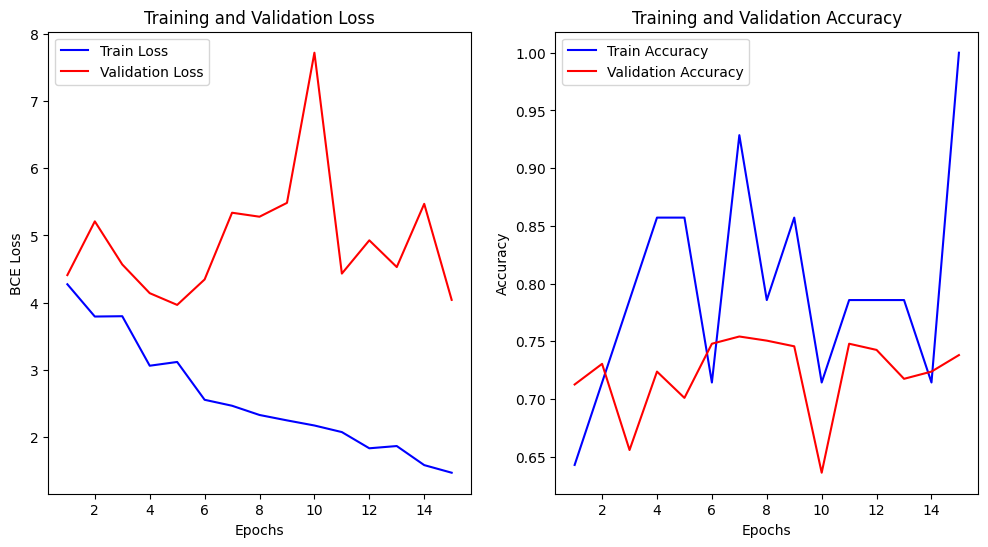

In [12]:
# Graph the error on each batch in the epoch I trained
graph_param = len(train_losses)+1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, graph_param),train_losses,color = 'blue',label = 'Train Loss')
plt.plot(range(1, graph_param),val_losses,color = 'red', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.subplot(1, 2, 2)
plt.plot(range(1, graph_param),train_accuracies,color = 'blue', label = 'Train Accuracy')
plt.plot(range(1, graph_param),val_accuracies,color = 'red', label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

In [13]:
LR_train_evaluation = test_model(LR_model,train_dataloader)
LR_val_evaluation = test_model(LR_model,val_dataloader)
LR_test_evaluation = test_model(LR_model,test_dataloader)
LR_evaluation = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Train": LR_train_evaluation,
    "Validation": LR_val_evaluation,
    "Test": LR_test_evaluation,
}
LR_evaluation = pd.DataFrame(LR_evaluation)
LR_evaluation

,Metric,Train,Validation,Test
0,Accuracy,0.915604,0.738042,0.737871
1,Precision,0.852554,0.501873,0.477528
2,Recall,0.821402,0.455782,0.491329
3,F1-Score,0.836688,0.477718,0.484330


**Train MLP Model**

In [14]:
# Prepare training and validation sets
train_dataset = TensorDataset(X_train_scaled_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = TensorDataset(X_val_scaled_tensor, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Early stopping parameters
patience = 3  # Number of epochs to wait before stopping if no improvement
min_delta = 1e-4  # Minimum change in validation loss to qualify as an improvement
best_val_loss = 999999  # Best validation loss observed
patience_counter = 0  # Counter for early stopping

loss_function = nn.BCELoss()
MLP_model = DirectMLP()
optimizer = torch.optim.Adam(MLP_model.parameters(), lr=0.001)
num_epochs = 80

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    MLP_model.train()
    
    batch_count = 0
    counter = 0
    epoch_loss = 0
    
    for inputs, labels in train_dataloader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = MLP_model(inputs)
        
        # Calculate the loss
        loss = loss_function(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        counter += 1
        #print(counter)
        
        epoch_loss += loss.item()
        batch_count += 1
        
        predicted_train = (outputs > 0.5).float()
        correct_train = (predicted_train == labels).sum().item()
        total_train = labels.size(0)
        
    train_losses.append(epoch_loss/batch_count)
    train_accuracies.append(correct_train/total_train)
    
    # Validation loop
    MLP_model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = MLP_model(inputs)
            
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            
            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    # Average validation loss
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
        
    # Print the loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[epoch]:.4f}, Val Loss: {val_loss:.4f}')
    
    # Early stopping logic
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience counter if validation loss improves
    else:
        patience_counter += 1
        print(f"Patience Counter: {patience_counter}/{patience}")
    
    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

Epoch [1/80], Train Loss: 11.9975, Val Loss: 5.8588
Epoch [2/80], Train Loss: 3.2824, Val Loss: 1.7058
Epoch [3/80], Train Loss: 1.4715, Val Loss: 2.0409
Patience Counter: 1/3
Epoch [4/80], Train Loss: 1.0900, Val Loss: 1.5857
Epoch [5/80], Train Loss: 0.7990, Val Loss: 2.5248
Patience Counter: 1/3
Epoch [6/80], Train Loss: 1.2466, Val Loss: 1.4652
Epoch [7/80], Train Loss: 0.8499, Val Loss: 1.1223
Epoch [8/80], Train Loss: 0.7970, Val Loss: 1.3351
Patience Counter: 1/3
Epoch [9/80], Train Loss: 0.5983, Val Loss: 1.2658
Patience Counter: 2/3
Epoch [10/80], Train Loss: 0.5126, Val Loss: 1.6203
Patience Counter: 3/3
Early stopping triggered!


Text(0.5, 1.0, 'Training and Validation Accuracy')

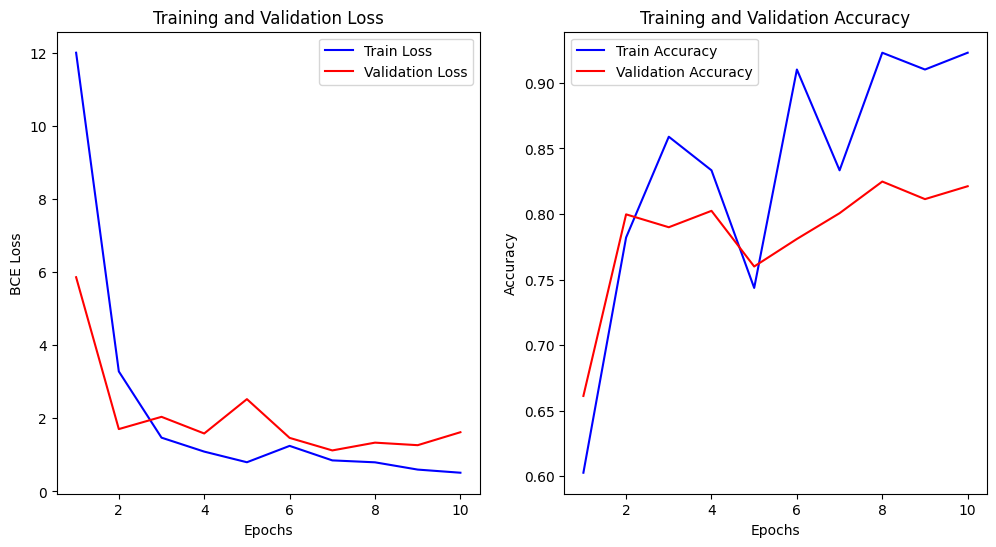

In [15]:
# Graph the error on each batch in the epoch I trained
graph_param = len(train_losses)+1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, graph_param),train_losses,color = 'blue',label = 'Train Loss')
plt.plot(range(1, graph_param),val_losses,color = 'red', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.subplot(1, 2, 2)
plt.plot(range(1, graph_param),train_accuracies,color = 'blue', label = 'Train Accuracy')
plt.plot(range(1, graph_param),val_accuracies,color = 'red', label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

In [16]:
MLP_train_evaluation = test_model(MLP_model,train_dataloader)
MLP_val_evaluation = test_model(MLP_model,val_dataloader)
MLP_test_evaluation = test_model(MLP_model,test_dataloader)
MLP_evaluation = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Train": MLP_train_evaluation,
    "Validation": MLP_val_evaluation,
    "Test": MLP_test_evaluation,
}
MLP_evaluation = pd.DataFrame(MLP_evaluation)
MLP_evaluation

,Metric,Train,Validation,Test
0,Accuracy,0.960844,0.821189,0.837799
1,Precision,0.950296,0.692623,0.711806
2,Recall,0.898210,0.574830,0.592486
3,F1-Score,0.923519,0.628253,0.646688


**Train Dropout Model**

In [17]:
# Prepare training and validation sets
train_dataset = TensorDataset(X_train_scaled_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)

val_dataset = TensorDataset(X_val_scaled_tensor, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)

# Early stopping parameters
patience = 5  # Number of epochs to wait before stopping if no improvement
min_delta = 1e-4  # Minimum change in validation loss to qualify as an improvement
best_val_loss = 999999  # Best validation loss observed
patience_counter = 0  # Counter for early stopping

loss_function = nn.BCELoss()
Dropout_model = DropoutMLP()
optimizer = torch.optim.Adam(Dropout_model.parameters(), lr=0.001)
num_epochs = 50

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    Dropout_model.train()
    
    batch_count = 0
    counter = 0
    epoch_loss = 0
    
    for inputs, labels in train_dataloader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = Dropout_model(inputs)
        
        # Calculate the loss
        loss = loss_function(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        counter += 1
        #print(counter)
        
        epoch_loss += loss.item()
        batch_count += 1
        
        predicted_train = (outputs > 0.5).float()
        correct_train = (predicted_train == labels).sum().item()
        total_train = labels.size(0)
        
    train_losses.append(epoch_loss/batch_count)
    train_accuracies.append(correct_train/total_train)
    
    # Validation loop
    Dropout_model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = Dropout_model(inputs)
            
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            
            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    # Average validation loss
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
        
    # Print the loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[epoch]:.4f}, Val Loss: {val_loss:.4f}')
    
    # Early stopping logic
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience counter if validation loss improves
    else:
        patience_counter += 1
        print(f"Patience Counter: {patience_counter}/{patience}")
    
    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

Epoch [1/50], Train Loss: 0.7501, Val Loss: 0.5031
Epoch [2/50], Train Loss: 0.5067, Val Loss: 0.4619
Epoch [3/50], Train Loss: 0.4669, Val Loss: 0.4239
Epoch [4/50], Train Loss: 0.4250, Val Loss: 0.4080
Epoch [5/50], Train Loss: 0.4029, Val Loss: 0.3973
Epoch [6/50], Train Loss: 0.3777, Val Loss: 0.3903
Epoch [7/50], Train Loss: 0.3532, Val Loss: 0.3844
Epoch [8/50], Train Loss: 0.3431, Val Loss: 0.3848
Patience Counter: 1/5
Epoch [9/50], Train Loss: 0.3329, Val Loss: 0.3862
Patience Counter: 2/5
Epoch [10/50], Train Loss: 0.3085, Val Loss: 0.3762
Epoch [11/50], Train Loss: 0.2900, Val Loss: 0.3989
Patience Counter: 1/5
Epoch [12/50], Train Loss: 0.2871, Val Loss: 0.3875
Patience Counter: 2/5
Epoch [13/50], Train Loss: 0.2749, Val Loss: 0.4069
Patience Counter: 3/5
Epoch [14/50], Train Loss: 0.2731, Val Loss: 0.3972
Patience Counter: 4/5
Epoch [15/50], Train Loss: 0.2517, Val Loss: 0.4122
Patience Counter: 5/5
Early stopping triggered!


Text(0.5, 1.0, 'Training and Validation Accuracy')

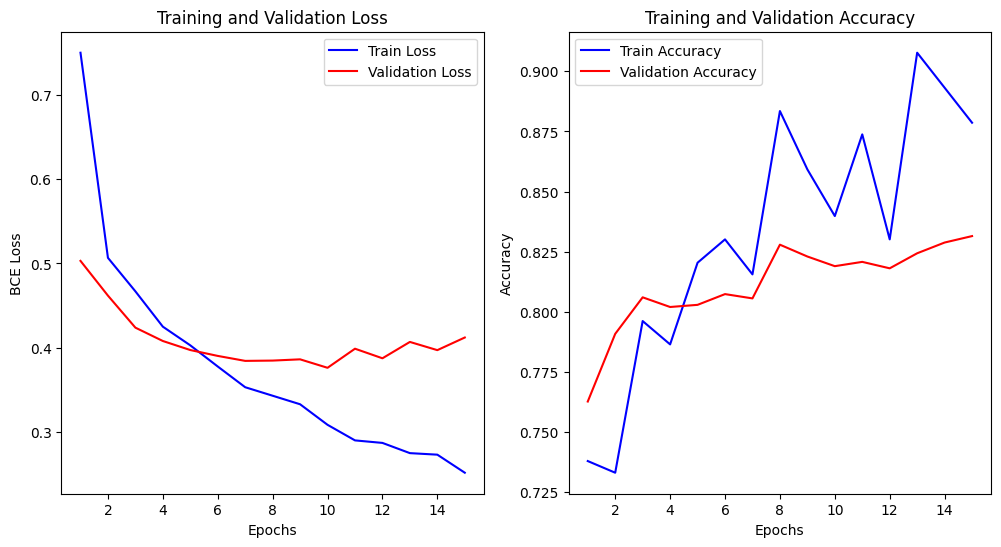

In [18]:
# Graph the error on each batch in the epoch I trained
graph_param = len(train_losses)+1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, graph_param),train_losses,color = 'blue',label = 'Train Loss')
plt.plot(range(1, graph_param),val_losses,color = 'red', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.subplot(1, 2, 2)
plt.plot(range(1, graph_param),train_accuracies,color = 'blue', label = 'Train Accuracy')
plt.plot(range(1, graph_param),val_accuracies,color = 'red', label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

In [19]:
Dropout_train_evaluation = test_model(Dropout_model,train_dataloader)
Dropout_val_evaluation = test_model(Dropout_model,val_dataloader)
Dropout_test_evaluation = test_model(Dropout_model,test_dataloader)
Dropout_evaluation = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Train": Dropout_train_evaluation,
    "Validation": Dropout_val_evaluation,
    "Test": Dropout_test_evaluation,
}
Dropout_evaluation = pd.DataFrame(Dropout_evaluation)
Dropout_evaluation

,Metric,Train,Validation,Test
0,Accuracy,0.930520,0.831471,0.847936
1,Precision,0.858648,0.684764,0.703593
2,Recall,0.881059,0.664966,0.679191
3,F1-Score,0.869709,0.674720,0.691176


**Train PCA Reduced Model**

In [20]:
# Prepare training and validation sets
train_dataset = TensorDataset(X_train_tensor_pca, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

val_dataset = TensorDataset(X_val_tensor_pca, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Early stopping parameters
patience = 2  # Number of epochs to wait before stopping if no improvement
min_delta = 1e-4  # Minimum change in validation loss to qualify as an improvement
best_val_loss = 999999  # Best validation loss observed
patience_counter = 0  # Counter for early stopping

loss_function = nn.BCELoss()
PCA_model = PCA_MLP()
optimizer = torch.optim.Adam(PCA_model.parameters(), lr=0.001)
num_epochs = 150

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    PCA_model.train()
    
    batch_count = 0
    counter = 0
    epoch_loss = 0
    
    for inputs, labels in train_dataloader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = PCA_model(inputs)
        
        # Calculate the loss
        loss = loss_function(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        counter += 1
        #print(counter)
        
        epoch_loss += loss.item()
        batch_count += 1
        
        predicted_train = (outputs > 0.5).float()
        correct_train = (predicted_train == labels).sum().item()
        total_train = labels.size(0)
        
    train_losses.append(epoch_loss/batch_count)
    train_accuracies.append(correct_train/total_train)
    
    # Validation loop
    PCA_model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = PCA_model(inputs)
            
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            
            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    # Average validation loss
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
        
    # Print the loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[epoch]:.4f}, Val Loss: {val_loss:.4f}')
    
    # Early stopping logic
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience counter if validation loss improves
    else:
        patience_counter += 1
        print(f"Patience Counter: {patience_counter}/{patience}")
    
    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x10 and 100x1)

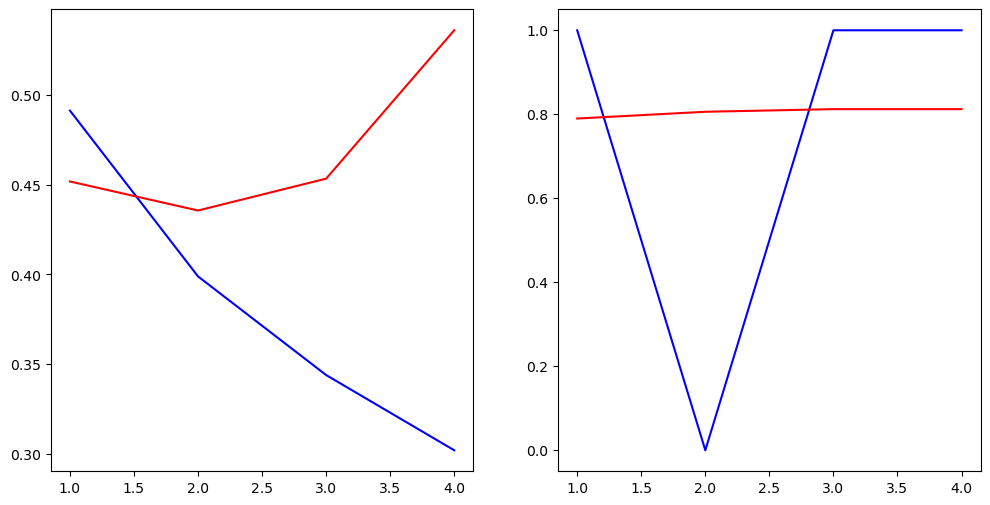

In [ ]:
# Graph the error on each batch in the epoch I trained
graph_param = len(train_losses)+1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, graph_param),train_losses,color = 'blue',label = 'Train Loss')
plt.plot(range(1, graph_param),val_losses,color = 'red', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.subplot(1, 2, 2)
plt.plot(range(1, graph_param),train_accuracies,color = 'blue', label = 'Train Accuracy')
plt.plot(range(1, graph_param),val_accuracies,color = 'red', label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

In [ ]:
test_dataset = TensorDataset(X_test_tensor_pca, y_test_tensor)
test_dataloader = DataLoader(test_dataset)

In [ ]:
PCA_train_evaluation = test_model(PCA_model,train_dataloader)
PCA_val_evaluation = test_model(PCA_model,val_dataloader)
PCA_test_evaluation = test_model(PCA_model,test_dataloader)
PCA_evaluation = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Train": PCA_train_evaluation,
    "Validation": PCA_val_evaluation,
    "Test": PCA_test_evaluation,
}
PCA_evaluation = pd.DataFrame(PCA_evaluation)
PCA_evaluation

,Metric,Train,Validation,Test
0,Accuracy,0.905496,0.812249,0.821868
1,Precision,0.915820,0.690909,0.701613
2,Recall,0.705817,0.517007,0.502890
3,F1-Score,0.797220,0.591440,0.585859


**Train PCA Model with Extra Parameters**

In [ ]:
# Prepare training and validation sets
train_dataset = TensorDataset(X_train_tensor_pca, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_val_tensor_pca, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Early stopping parameters
patience = 8  # Number of epochs to wait before stopping if no improvement
min_delta = 1e-4  # Minimum change in validation loss to qualify as an improvement
best_val_loss = 999999  # Best validation loss observed
patience_counter = 0  # Counter for early stopping

loss_function = nn.BCELoss()
PCAX_model = PCA_ExtraParam_MLP()
optimizer = torch.optim.Adam(PCAX_model.parameters(), lr=0.001)
num_epochs = 75

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    PCAX_model.train()
    
    batch_count = 0
    counter = 0
    epoch_loss = 0
    
    for inputs, labels in train_dataloader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = PCAX_model(inputs)
        
        # Calculate the loss
        loss = loss_function(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        counter += 1
        #print(counter)
        
        epoch_loss += loss.item()
        batch_count += 1
        
        predicted_train = (outputs > 0.5).float()
        correct_train = (predicted_train == labels).sum().item()
        total_train = labels.size(0)
        
    train_losses.append(epoch_loss/batch_count)
    train_accuracies.append(correct_train/total_train)
    
    # Validation loop
    PCAX_model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = PCAX_model(inputs)
            
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            
            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    # Average validation loss
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
        
    # Print the loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[epoch]:.4f}, Val Loss: {val_loss:.4f}')
    
    # Early stopping logic
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience counter if validation loss improves
    else:
        patience_counter += 1
        print(f"Patience Counter: {patience_counter}/{patience}")
    
    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

Epoch [1/75], Train Loss: 0.4445, Val Loss: 0.4062
Epoch [2/75], Train Loss: 0.3169, Val Loss: 0.3960
Epoch [3/75], Train Loss: 0.2346, Val Loss: 0.4439
Patience Counter: 1/8
Epoch [4/75], Train Loss: 0.1673, Val Loss: 0.5798
Patience Counter: 2/8
Epoch [5/75], Train Loss: 0.1267, Val Loss: 0.7056
Patience Counter: 3/8
Epoch [6/75], Train Loss: 0.0896, Val Loss: 0.7594
Patience Counter: 4/8
Epoch [7/75], Train Loss: 0.0673, Val Loss: 0.9649
Patience Counter: 5/8
Epoch [8/75], Train Loss: 0.0471, Val Loss: 1.0129
Patience Counter: 6/8
Epoch [9/75], Train Loss: 0.0407, Val Loss: 1.0752
Patience Counter: 7/8
Epoch [10/75], Train Loss: 0.0400, Val Loss: 0.9953
Patience Counter: 8/8
Early stopping triggered!


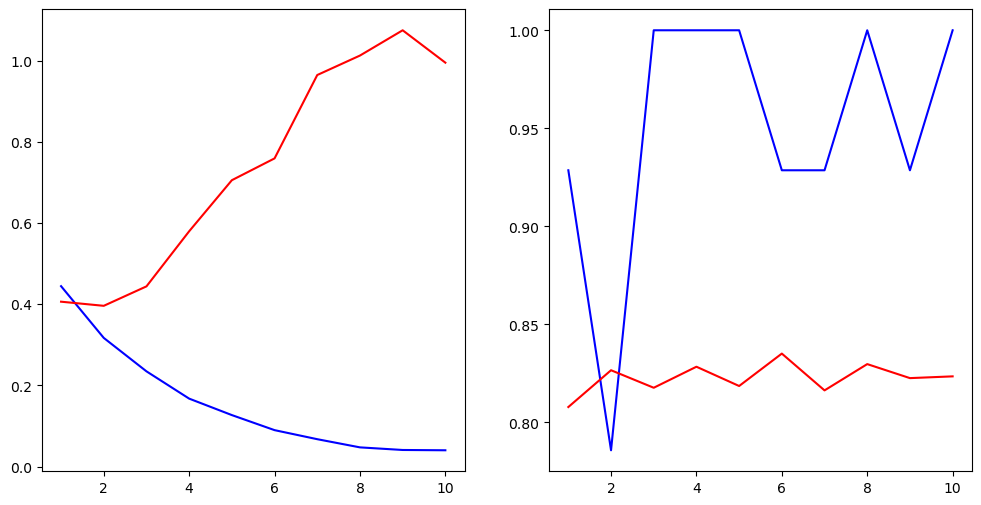

In [ ]:
# Graph the error on each batch in the epoch I trained
graph_param = len(train_losses)+1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, graph_param),train_losses,color = 'blue',label = 'Train Loss')
plt.plot(range(1, graph_param),val_losses,color = 'red', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.subplot(1, 2, 2)
plt.plot(range(1, graph_param),train_accuracies,color = 'blue', label = 'Train Accuracy')
plt.plot(range(1, graph_param),val_accuracies,color = 'red', label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

In [ ]:
PCAX_train_evaluation = test_model(PCA_model,train_dataloader)
PCAX_val_evaluation = test_model(PCA_model,val_dataloader)
PCAX_test_evaluation = test_model(PCA_model,test_dataloader)
PCAX_evaluation = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Train": PCAX_train_evaluation,
    "Validation": PCAX_val_evaluation,
    "Test": PCAX_test_evaluation,
}
PCAX_evaluation = pd.DataFrame(PCAX_evaluation)
PCAX_evaluation

,Metric,Train,Validation,Test
0,Accuracy,0.919921,0.816272,0.811731
1,Precision,0.851810,0.657194,0.631902
2,Recall,0.842282,0.629252,0.595376
3,F1-Score,0.847019,0.642919,0.613095


Part 2

### IMPORTS

In [ ]:
import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
import numpy as np
# Replace this with your dataset's root path
from kagglehub import dataset_download


### Preprocess DataSet

In [ ]:
### HELPER FUNCTIONS
def get_subdirectories(folder_path):
    subdirectory_path_list = []
    subdirectory_names = os.listdir(folder_path)

    for subdirectories in subdirectory_names:
        full_path = os.path.join(folder_path, subdirectories)
        subdirectory_path_list.append(full_path)
    
    return subdirectory_path_list


def get_image(image_file):
    # Load the image
    image = Image.open(image_file)
    # Convert the image to a NumPy array
    image_array = np.array(image)
    return image_array

def preprocess_dataset(class_files):
    label_list  = []

    for i in range(len(class_files)):
        subdirectories = get_subdirectories(class_files[i])
        subdirectories.sort()

        class_files[i] = subdirectories
        
        for sub in subdirectories: 
            label_list.append(i)

    #Combining the classes together
    concated_list = []
    for classes in class_files:
        concated_list.extend(classes)

    #Shuffling the classes
    concated_list = np.array(concated_list)
    label_list = np.array(label_list)

    # Generate a random permutation of indices
    indices = np.random.permutation(len(concated_list))

    # Apply the permutation to both lists
    shuffled_class_list = concated_list[indices]
    shuffled_label_list = label_list[indices]
    
    shuffled_class_list = [get_image(image_file) for image_file in shuffled_class_list]

    return shuffled_class_list, shuffled_label_list

# Step 1: Download dataset
path = dataset_download("tawsifurrahman/covid19-radiography-database")
print("Dataset downloaded to:", path)

dataset_path = path  # Replace with actual path

file = get_subdirectories(path)
print(file)

files_list = get_subdirectories(file[0])
files_list.sort()
print(np.array(files_list))
#Getting the files from the dataset
normal_file = get_subdirectories(files_list[4])
normal_file.sort()
print(normal_file)

covid_file =  get_subdirectories(files_list[0])
covid_file.sort()
print(covid_file)

normal_images = normal_file[0]
# print(normal_images)

covid_images = covid_file[0]
# print(covid_images)
class_files = [covid_images, normal_images]
class_files, label_list = preprocess_dataset(class_files)


Dataset downloaded to: /home/smg0092/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5
['/home/smg0092/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset']
['/home/smg0092/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset/COVID'
 '/home/smg0092/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset/COVID.metadata.xlsx'
 '/home/smg0092/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset/Lung_Opacity'
 '/home/smg0092/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx'
 '/home/smg0092/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset/Normal'
 '/home/smg0092/.cache/kagglehub/datasets/taws

### CNN MODEL Compile and Report

In [ ]:
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

X, y = np.array(class_files), np.array(label_list)
print(X.shape)
print(y.shape)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

# Add a channel dimension: Shape becomes (100, 299, 299, 1)
X = np.expand_dims(X, axis=-1)
# Normalize pixel values to range [0, 1]
X = X / 255.0


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 1)),  # Input shape includes the channel
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # Adjust the output layer for your number of classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


model_hist = model.fit(X_train, y_train, epochs=60, validation_data=(X_test, y_test))

score = model.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

y_pred = model.predict(X_test)  # Get predictions for the test data
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels
y_true = y_test  # True labels for the test data
label_dict = {"Covid": 0, "Normal": 1}
report = classification_report(y_true, y_pred_classes, target_names=label_dict)
print(report)

(13808, 299, 299)
(13808,)


/home/smg0092/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 297, 297, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 148, 148, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 146, 146, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 156800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    20,070,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,164,490 (76.92 MB)

 Trainable params: 20,164,490 (76.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7268 - loss: 29.7758

2024-11-27 18:50:30.038552: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_84', 4 bytes spill stores, 4 bytes spill loads



303/303 ━━━━━━━━━━━━━━━━━━━━ 26s 63ms/step - accuracy: 0.7271 - loss: 29.6985 - val_accuracy: 0.8552 - val_loss: 0.2932
Epoch 2/60
303/303 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.8637 - loss: 0.3138 - val_accuracy: 0.8747 - val_loss: 0.2622
Epoch 3/60
303/303 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.8935 - loss: 0.2626 - val_accuracy: 0.8860 - val_loss: 0.2725
Epoch 4/60
303/303 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.8892 - loss: 0.3332 - val_accuracy: 0.8715 - val_loss: 0.3091
Epoch 5/60
303/303 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.8855 - loss: 0.3032 - val_accuracy: 0.9059 - val_loss: 0.2433
Epoch 6/60
303/303 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.9270 - loss: 0.1874 - val_accuracy: 0.9070 - val_loss: 0.2359
Epoch 7/60
303/303 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.9366 - loss: 0.1581 - val_accuracy: 0.9185 - val_loss: 0.2432
Epoch 8/60
303/303 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.9475 - loss: 0.1401 - val_accura

### Compile, Run, and Evaluate LSTM_RNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Flatten


X, y = np.array(class_files), np.array(label_list)
print(X.shape)
print(y.shape)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

# Add a channel dimension: Shape becomes (100, 299, 299, 1)
X = np.expand_dims(X, axis=-1)
# Normalize pixel values to range [0, 1]
X = X / 255.0


# Define an RNN for grayscale images
def build_rnn_for_grayscale(input_shape=(128, 128), num_classes=10, rnn_type='LSTM'):
    height, width = input_shape  # Image dimensions
    model = Sequential()

    # Choose the RNN type
    if rnn_type == 'LSTM':
        model.add(LSTM(128, activation='relu', input_shape=(height, width), return_sequences=True))
        model.add(LSTM(64, activation='relu'))

    # Fully connected output layer
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model



# Example usage
input_shape = (299, 299) 
num_classes = 2 
rnn_model = build_rnn_for_grayscale(input_shape=input_shape, num_classes=num_classes, rnn_type='LSTM')

# Print the model summary
rnn_model.summary()
rnn_hist = rnn_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


(13808, 299, 299)
(13808,)


/home/smg0092/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 299, 128)       │       219,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,122 (1.06 MB)

 Trainable params: 277,122 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.7265 - loss: nan - val_accuracy: 0.7375 - val_loss: nan
Epoch 2/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.7264 - loss: nan - val_accuracy: 0.7375 - val_loss: nan
Epoch 3/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.7334 - loss: nan - val_accuracy: 0.7375 - val_loss: nan
Epoch 4/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.7333 - loss: nan - val_accuracy: 0.7375 - val_loss: nan
Epoch 5/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.7288 - loss: nan - val_accuracy: 0.7375 - val_loss: nan
Epoch 6/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - accuracy: 0.7388 - loss: nan - val_accuracy: 0.7375 - val_loss: nan
Epoch 7/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.7330 - loss: nan - val_accuracy: 0.7375 - val_loss: nan
Epoch 8/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.7399 - loss: nan - val_accuracy: 0.7375 - val_loss: nan
Epoch 9/

### RNN REPORT

In [ ]:
score = rnn_model.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

y_pred = rnn_model.predict(X_test)  
y_pred_classes = np.argmax(y_pred, axis=1)  
y_true = y_test  
label_dict = {"Covid": 0, "Normal": 1}

report = classification_report(y_true, y_pred_classes, target_names=label_dict)
print(report)

87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7255 - loss: nan
Test loss: nan
Test accuracy: 0.7375090718269348
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
              precision    recall  f1-score   support

       Covid       0.26      1.00      0.42       725
      Normal       0.00      0.00      0.00      2037

    accuracy                           0.26      2762
   macro avg       0.13      0.50      0.21      2762
weighted avg       0.07      0.26      0.11      2762



/home/smg0092/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/smg0092/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/smg0092/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### VGG Preprocessing and Compilation

In [ ]:
parent_folder = "new_folder"  

covid_single_images = get_subdirectories(covid_images)
normal_single_images = get_subdirectories(normal_images)

DataSet_size = len(covid_single_images) + len(normal_single_images)

print(DataSet_size)

13808


### Building/Running the Model

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.applications import VGG16
from keras.optimizers import Adam

def vgg(nativeset, data_directory, num_classes, dataset_size, numofruns, epochs, doubledense, finetuning, name):
    f = open(name[0], "w")
    plot = open(name[1], "w")
    acclist_training = []
    acclist_validation = []
    acclist_test = []
    
    for i in range(numofruns):
        full_dataset = tf.keras.utils.image_dataset_from_directory(
            data_directory,
            color_mode="grayscale",  # Load as grayscale
            batch_size=None,  
            seed=42,
            shuffle=False
        )

        def convert_to_rgb(image, label):
        
            if image.shape[-1] == 1:  
                image = tf.image.grayscale_to_rgb(image)
            image = tf.image.resize(image, (224, 224)) / 255.0
            return image, label

        
        full_dataset = full_dataset.map(convert_to_rgb)
        full_dataset = full_dataset.shuffle(dataset_size, seed=42, reshuffle_each_iteration=False)

        
        train_size = int(0.8 * dataset_size)
        val_size = int(0.1 * dataset_size)
        test_size = dataset_size - train_size - val_size
        training_set = full_dataset.take(train_size)
        validation_set = full_dataset.skip(train_size).take(val_size)
        test_set = full_dataset.skip(train_size + val_size)

        # Define VGG16-based model
        base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
        base_model.trainable = finetuning

        new_model = Sequential([
            base_model,
            Flatten(),
            Dense(1024, activation='relu'),
            Dense(1024, activation='relu') if doubledense else Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])

        new_model.compile(
            optimizer=Adam(learning_rate=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
        )

        # Prepare datasets for training
        BATCH_SIZE = 16
        train_batches = training_set.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
        validation_batches = validation_set.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
        test_batches = test_set.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

        # Train the model
        history = new_model.fit(
            train_batches,
            epochs=epochs,
            validation_data=validation_batches,
        )

        # Record results
        acc = history.history['sparse_categorical_accuracy']
        val_acc = history.history['val_sparse_categorical_accuracy']
        acclist_training.append(max(acc))
        acclist_validation.append(max(val_acc))
        result_test = new_model.evaluate(test_batches)

        f.write(f"Run {i + 1}:\n")
        f.write(f"Training Accuracy: {max(acc):.2%}\n")
        f.write(f"Validation Accuracy: {max(val_acc):.2%}\n")
        f.write(f"Test Accuracy: {result_test[1]:.2%}\n\n")
        f.flush()

    # Summary statistics
    f.write("Summary:\n")
    f.write(f"Max Training Accuracy: {max(acclist_training):.2%}\n")
    f.write(f"Max Validation Accuracy: {max(acclist_validation):.2%}\n")
    f.write(f"Average Test Accuracy: {np.mean(acclist_test):.2%}\n")
    f.close()
    plot.close()

    print("Training complete.")


data_directory = "new_folder"  
vgg(
    nativeset=False,
    data_directory=data_directory,
    num_classes=2,
    dataset_size=DataSet_size,
    numofruns=5,
    epochs=10,
    doubledense=False,
    finetuning=False,
    name=["results.txt", "plot.txt"]
)


Found 13808 files belonging to 2 classes.
Epoch 1/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.3760 - sparse_categorical_accuracy: 0.8326

2024-11-27 19:20:48.189316: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_194', 8 bytes spill stores, 8 bytes spill loads

2024-11-27 19:20:48.407006: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_194', 100 bytes spill stores, 100 bytes spill loads



691/691 ━━━━━━━━━━━━━━━━━━━━ 57s 70ms/step - loss: 0.3758 - sparse_categorical_accuracy: 0.8326 - val_loss: 0.1469 - val_sparse_categorical_accuracy: 0.9565
Epoch 2/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 46s 64ms/step - loss: 0.1434 - sparse_categorical_accuracy: 0.9503 - val_loss: 0.1047 - val_sparse_categorical_accuracy: 0.9710
Epoch 3/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 47s 64ms/step - loss: 0.1019 - sparse_categorical_accuracy: 0.9658 - val_loss: 0.0870 - val_sparse_categorical_accuracy: 0.9732
Epoch 4/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 46s 64ms/step - loss: 0.0798 - sparse_categorical_accuracy: 0.9748 - val_loss: 0.0754 - val_sparse_categorical_accuracy: 0.9754
Epoch 5/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 46s 64ms/step - loss: 0.0689 - sparse_categorical_accuracy: 0.9791 - val_loss: 0.0682 - val_sparse_categorical_accuracy: 0.9783
Epoch 6/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 46s 64ms/step - loss: 0.0596 - sparse_categorical_accuracy: 0.9802 - val_loss: 0.0640 - val_sparse_categorical_accuracy: 0.9804
Epo

/home/smg0092/myenv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/smg0092/myenv/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Vgg Run Results: 


Run 1:
- Training Accuracy: 99.05%
- Validation Accuracy: 98.55%
- Test Accuracy: 98.19%

Run 2:
- Training Accuracy: 99.02%
- Validation Accuracy: 98.33%
- Test Accuracy: 98.12%

Run 3:
- Training Accuracy: 99.18%
- Validation Accuracy: 98.55%
- Test Accuracy: 98.19%

Run 4:
- Training Accuracy: 98.97%
- Validation Accuracy: 98.48%
- Test Accuracy: 98.19%

Run 5:
- Training Accuracy: 99.00%
- Validation Accuracy: 98.48%
- Test Accuracy: 98.26%

Summary:
- Max Training Accuracy: 99.18%
- Max Validation Accuracy: 98.55%
- Average Test Accuracy: nan%